In [1]:
import numpy as np
from scipy.stats import beta, chi2_contingency
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
np.random.seed(2024)

In [3]:
# Number of observations
n = int(1e4)

# Simulation of 2 binary SA (dependent)
A = np.random.choice(['a', 'b', 'c', 'd'], size = n, p = [0.3, 0.1, 0.2, 0.4])

# First MSA
A1 = np.isin(A, ['b', 'd']).astype(int)

# Second MSA
A2 = np.isin(A, ['c', 'd']).astype(int)

# Third MSA
A3 = np.zeros(n, dtype=int)  # Initialize A3 as a binary array of zeros
A3[(A1 == 1) & (A2 == 1)] = np.random.choice([0, 1], size=sum((A1 == 1) & (A2 == 1)), p=[0.1, 0.9])
A3[(A1 == 1) & (A2 == 0)] = np.random.choice([0, 1], size=sum((A1 == 1) & (A2 == 0)), p=[0.3, 0.7])
A3[(A1 == 0) & (A2 == 1)] = np.random.choice([0, 1], size=sum((A1 == 0) & (A2 == 1)), p=[0.5, 0.5])
A3[(A1 == 0) & (A2 == 0)] = np.random.choice([0, 1], size=sum((A1 == 0) & (A2 == 0)), p=[0.8, 0.2])

# H0: A1 and A2 are independent
contingency_table = np.histogram2d(A1, A2, bins=[2, 2])[0]
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared test p-value: {p}")

Chi-squared test p-value: 0.0


In [4]:
# Parameters of Beta distribution for \hat{Y} depending on A1 and A2
# We imitate score predictions between [0,1] of a Machine Learning model
param_alpha = (A1 == 0) * (A2 == 0) * (A3 == 0) * 8 + (A1 == 1) * (A2 == 0) * (A3 == 0) * 5 + \
              (A1 == 0) * (A2 == 1) * (A3 == 0) * 4 + (A1 == 1) * (A2 == 1) * (A3 == 0) * 2.2 + \
              (A1 == 0) * (A2 == 0) * (A3 == 1) * 7 + (A1 == 1) * (A2 == 0) * (A3 == 1) * 4.8 + \
              (A1 == 0) * (A2 == 1) * (A3 == 1) * 3.5 + (A1 == 1) * (A2 == 1) * (A3 == 1) * 2.5

param_beta = (A1 == 0) * (A2 == 0) * (A3 == 0) * 2 + (A1 == 1) * (A2 == 0) * (A3 == 0) * 4.5 + \
             (A1 == 0) * (A2 == 1) * (A3 == 0) * 5.1 + (A1 == 1) * (A2 == 1) * (A3 == 0) * 9 + \
             (A1 == 0) * (A2 == 0) * (A3 == 1) * 3 + (A1 == 1) * (A2 == 0) * (A3 == 1) * 4.2 + \
             (A1 == 0) * (A2 == 1) * (A3 == 1) * 6.3 + (A1 == 1) * (A2 == 1) * (A3 == 1) * 8.7

# Simulation of Beta distributions: predicted scores to mitigate
scores = beta.rvs(param_alpha, param_beta, size = n)

In [5]:
X = pd.DataFrame({
    'A1': A1,
    'A2': A2,
    'A3': A3
})

In [6]:
# Split the data into training and testing sets
X_calib, X_test, scores_calib, scores_test = train_test_split(X, scores, test_size=0.3, random_state=42)

In [7]:
from equipy.fairness import MultiWasserstein

In [8]:
msa_123_wst = MultiWasserstein()
msa_123_wst.fit(scores_calib, X_calib)

In [9]:
fair_scores_msa_123 = msa_123_wst.transform(scores_test, X_test)
print("y_fair :", fair_scores_msa_123)

y_fair : [0.68148284 0.51830108 0.60751932 ... 0.53593012 0.58106599 0.42060079]


In [10]:
from equipy.metrics import unfairness
print(f"Unfairness before mitigation: {unfairness(scores_test, X_test):.2f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(fair_scores_msa_123, X_test):.2f}")

Unfairness before mitigation: 1.02
Unfairness after mitigating biases from origin and sex: 0.04


In [11]:
y_seq_fair = msa_123_wst.get_sequential_fairness()

In [12]:
from equipy.graphs import fair_density_plot

array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A3', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A3', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A3', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Den

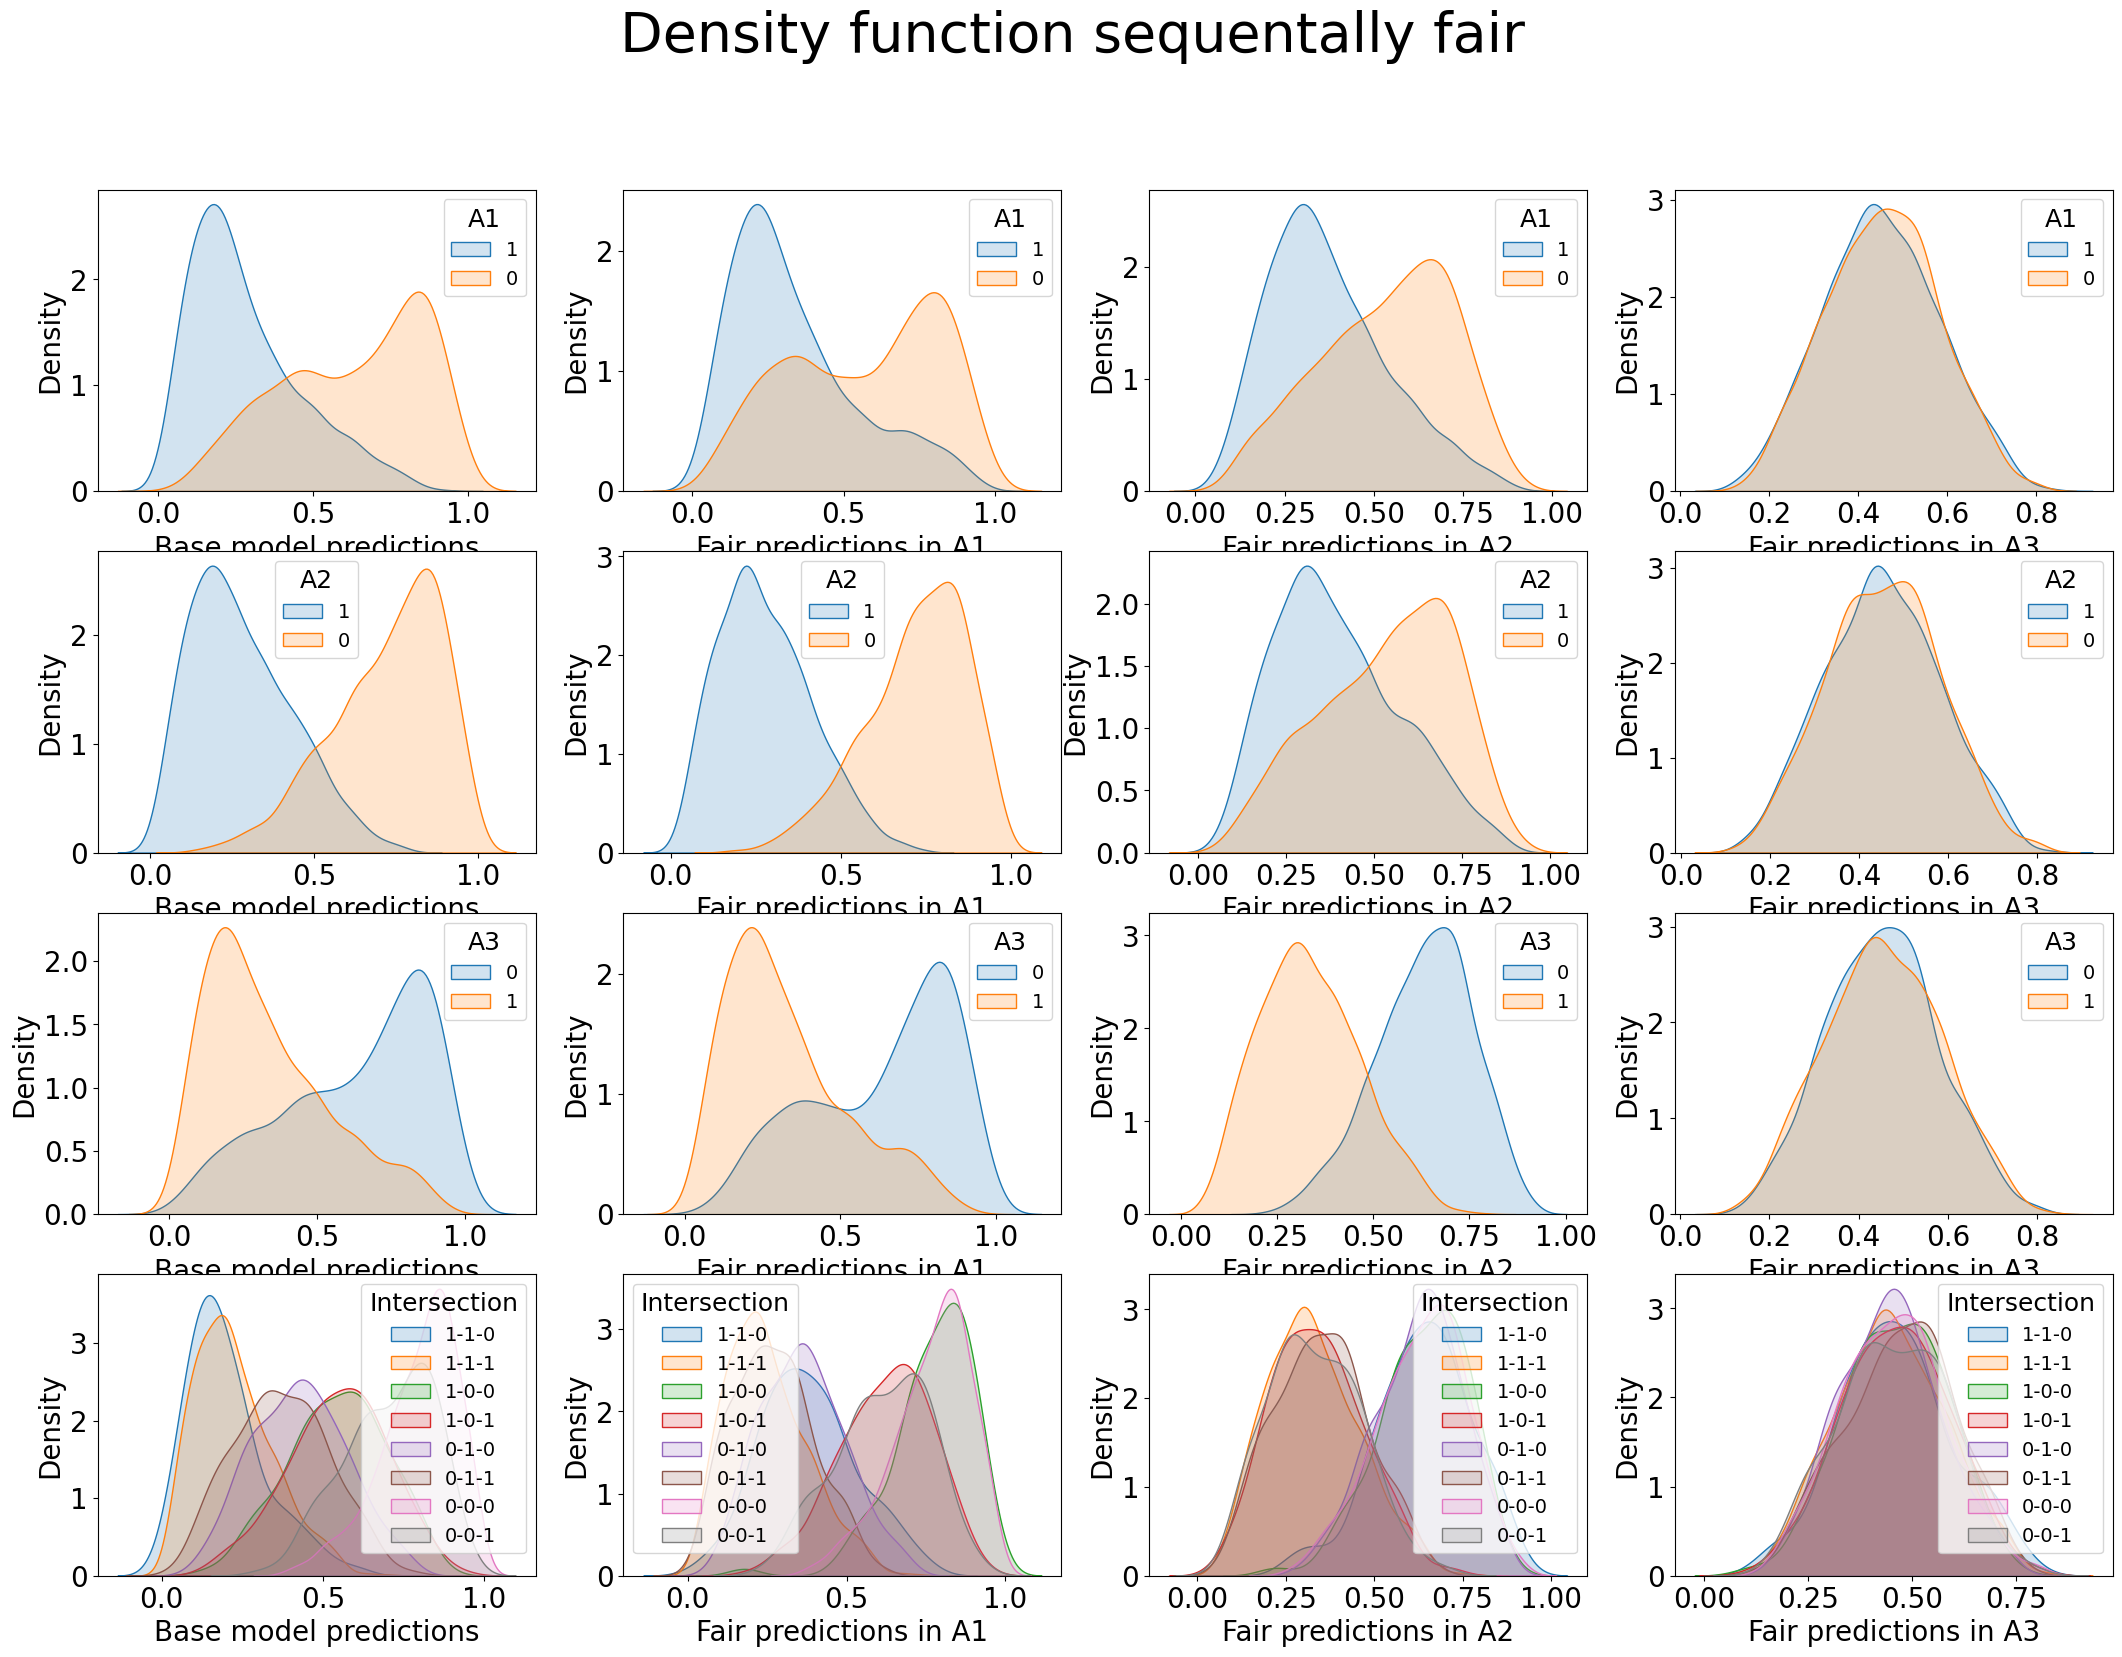

In [13]:
fair_density_plot(X_calib, X_test, scores_calib, scores_test)

In [14]:
from equipy.graphs import fair_multiple_arrow_plot

In [15]:
noisy_scores_test = scores_test + np.random.uniform(-0.01, 0.01, size=np.size(scores_test))

<Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>

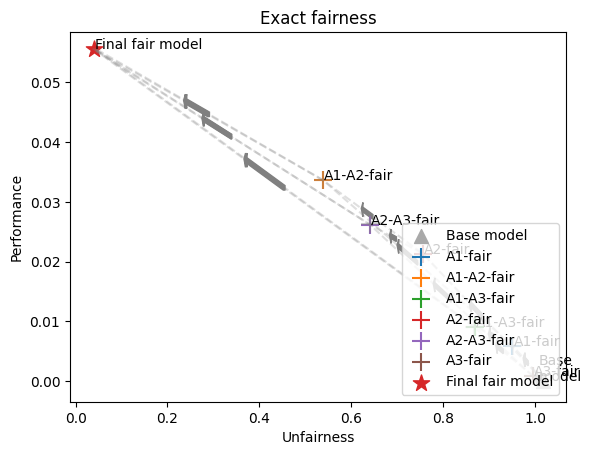

In [16]:
fair_multiple_arrow_plot(X_calib, X_test, scores_calib, scores_test, noisy_scores_test)

In [17]:
# Apply the mapping
X['new_A'] = X.apply(lambda row: ''.join(row.astype(str)), axis=1)
X_ssa = X[['new_A']]

In [18]:
# Split the data into training and testing sets
X_ssa_calib, X_ssa_test, scores_calib, scores_test = train_test_split(X_ssa, scores, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets to confirm the split
print("Training DataFrame shape:", X_ssa_calib.shape)
print("Testing DataFrame shape:", X_ssa_test.shape)
print("Training x shape:", scores_calib.shape)
print("Testing x shape:", scores_test.shape)

Training DataFrame shape: (7000, 1)
Testing DataFrame shape: (3000, 1)
Training x shape: (7000,)
Testing x shape: (3000,)


In [19]:
from equipy.fairness import FairWasserstein
ssa_wst = FairWasserstein()
ssa_wst.fit(scores_calib, X_ssa_calib)
fair_scores_ssa = ssa_wst.transform(scores_test, X_ssa_test)
print("y_fair :", fair_scores_ssa)

y_fair : [0.68108805 0.51804827 0.60752166 ... 0.53870334 0.58112252 0.42069844]


In [20]:
from equipy.metrics import unfairness
print(f"Unfairness before mitigation: {unfairness(scores_test, X_ssa_test):.2f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(fair_scores_ssa, X_ssa_test):.2f}")

Unfairness before mitigation: 0.52
Unfairness after mitigating biases from origin and sex: 0.06


array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in new_A', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in new_A', ylabel='Density'>]],
      dtype=object)

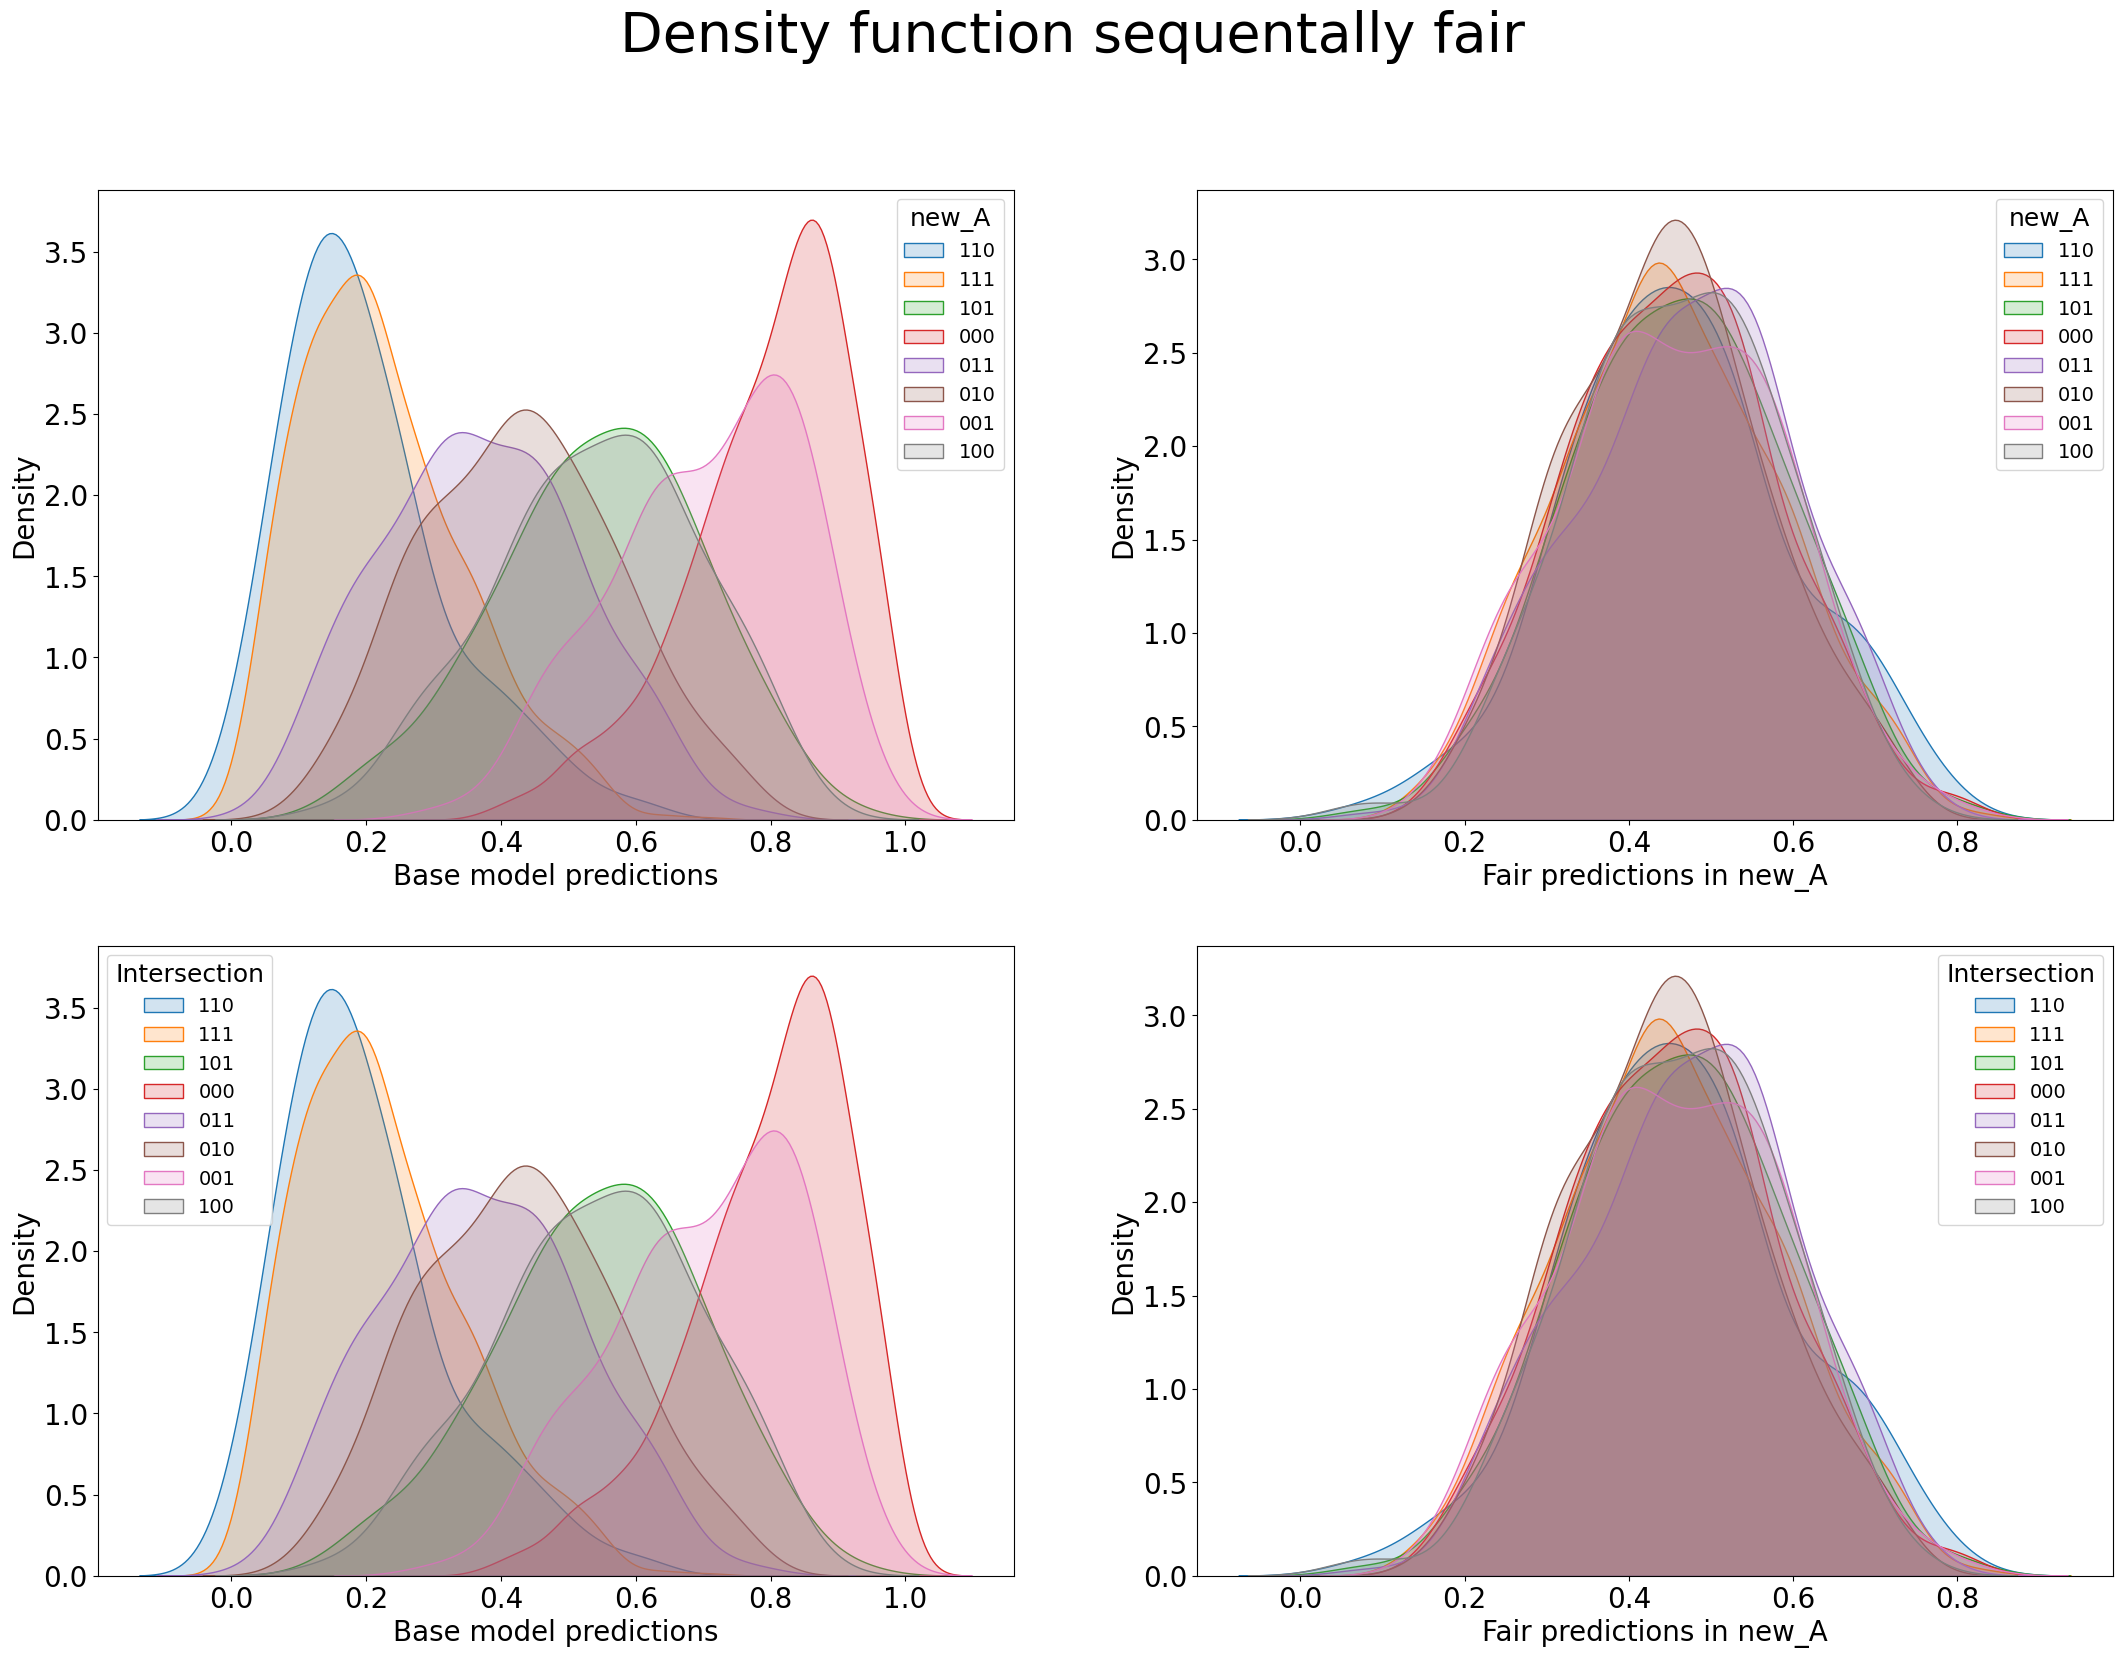

In [21]:
fair_density_plot(X_ssa_calib, X_ssa_test, scores_calib, scores_test)

array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A3', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A3', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A3', ylabel='Density'>],
       [<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A1', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in A2', ylabel='Den

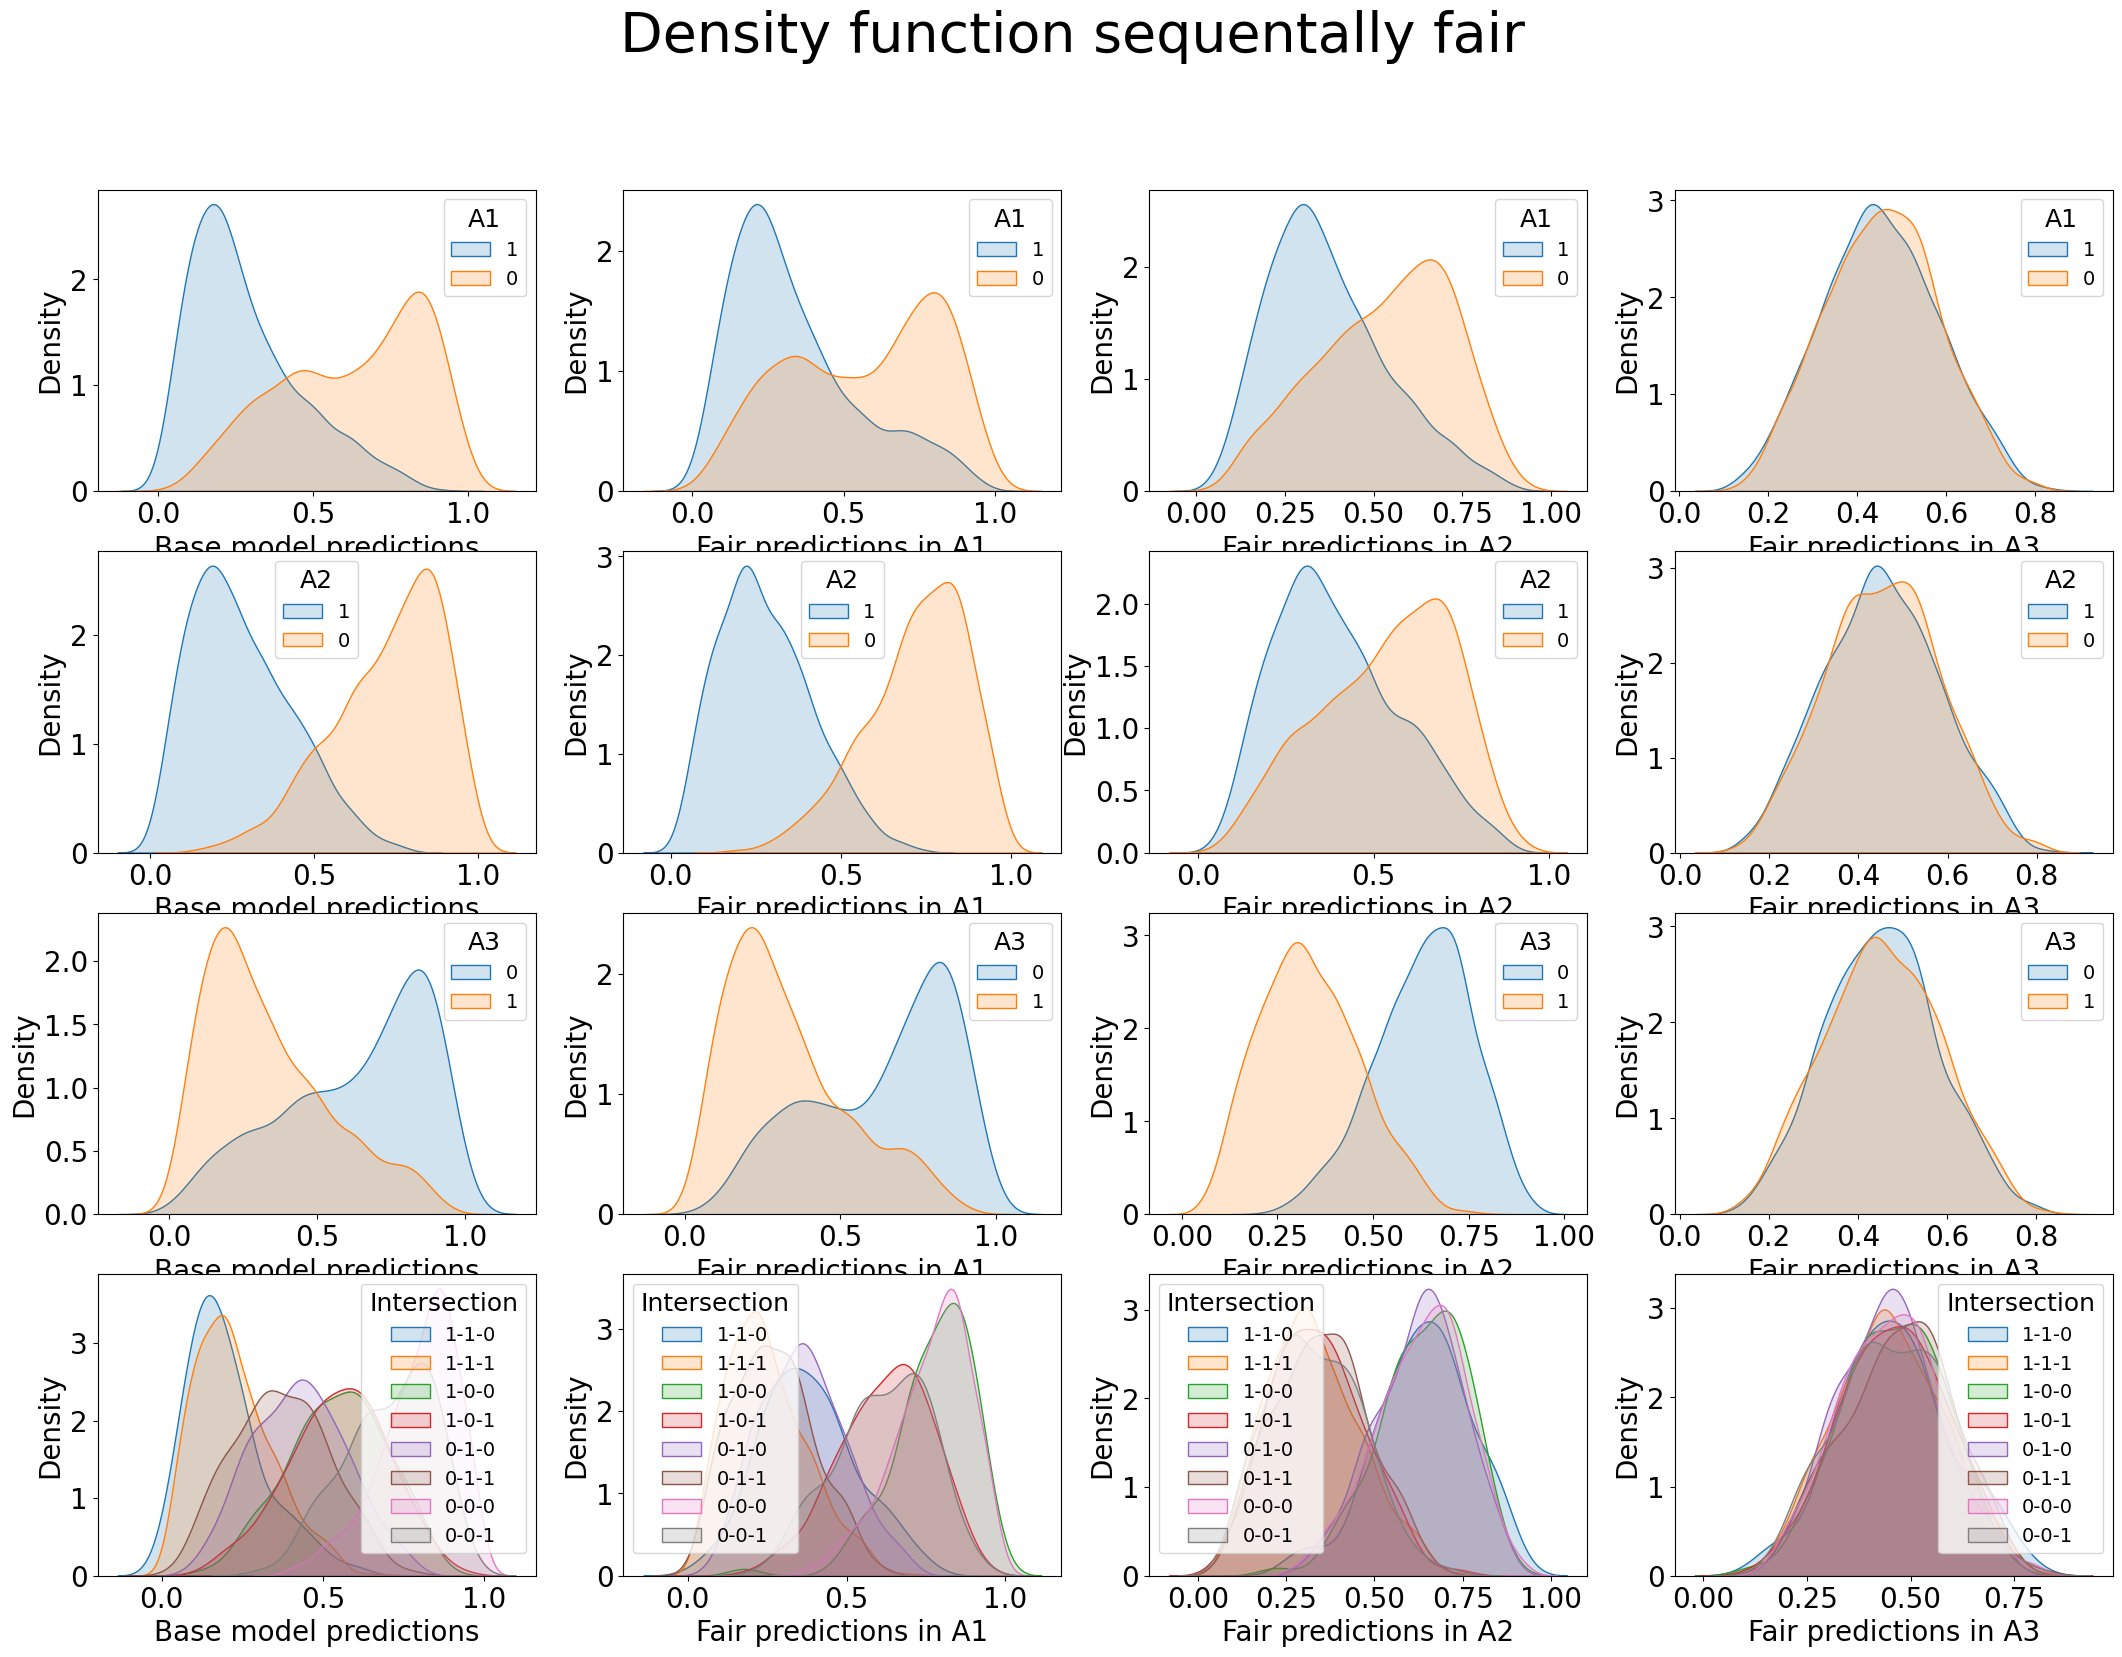

In [22]:
fair_density_plot(X_calib, X_test, scores_calib, scores_test)